In [4]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# two levels up from the notebook to project root, then append to sys.path
sys.path.append(str(Path().resolve().parents[1]))

from utils.data_loading import load_datasets
from utils.data_preparation import get_spo2_to_po2_interpolator, add_shift_raw_column
from utils.evaluation import evaluate_macro_patient_level, print_evaluation, bland_altman_plots
from utils.modeling import fit_cv_models, predict_cv_ensemble


train_df, test_df, odc = load_datasets()
spo2_to_po2 = get_spo2_to_po2_interpolator(odc)

train_df = add_shift_raw_column(train_df, spo2_to_po2)
test_df  = add_shift_raw_column(test_df, spo2_to_po2)

In [5]:
from sklearn.linear_model import LinearRegression

In [6]:

test_df  = test_df[test_df['SpO2(%)'] < 95].copy()

# Create log feature
train_df['log_PiO2'] = np.log(train_df['Insp.O2(kPa)'])
test_df['log_PiO2'] = np.log(test_df['Insp.O2(kPa)'])

# ===============================================================

features = ['shift_raw', 'log_PiO2', 'SpO2(%)']

# Train ensemble of CV models
cv_models = fit_cv_models(
    train_df,
    features=features,
    target_col='shift',
    model_class=LinearRegression,
    k=10
)

# Predict on test set (average over CV models)
test_df['y_pred'] = predict_cv_ensemble(test_df, features, cv_models)

# Evaluate macro-averaged patient metrics
summary = evaluate_macro_patient_level(test_df, y_true_col='shift', y_pred_col='y_pred')
print_evaluation(summary)


Macro-averaged per-patient metrics:
MAE  = 0.804
MSE  = 1.404
RMSE = 0.948
Bias = 0.047


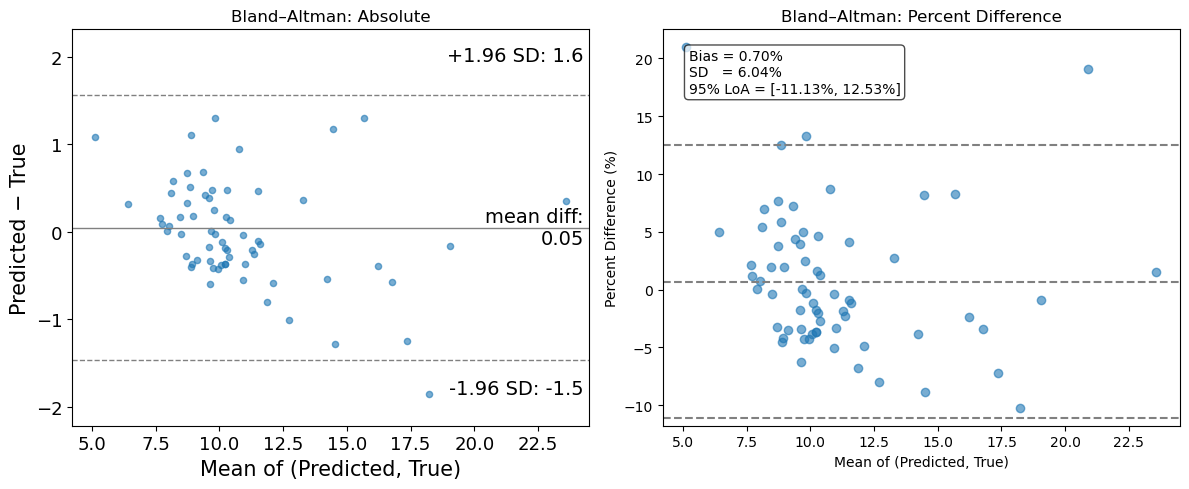

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'Bland–Altman: Absolute'}, xlabel='Mean of (Predicted, True)', ylabel='Predicted − True'>,
        <Axes: title={'center': 'Bland–Altman: Percent Difference'}, xlabel='Mean of (Predicted, True)', ylabel='Percent Difference (%)'>],
       dtype=object))

In [8]:
bland_altman_plots(test_df, y_true_col='shift', y_pred_col='y_pred', group_col='Anon.Patient_ID')
